In [51]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist

In [3]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [8]:
# Format the data to work with existing code
labels = node_labels

# just look at first timepoint
dense_adj = As[0]

100%|██████████| 100/100 [00:03<00:00, 30.52it/s]


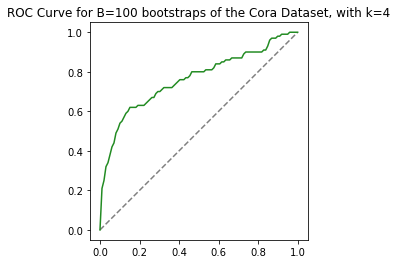

Total area (above and below y=x): 0.26462299765330066 for k=4


In [48]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

k = 4
B = 10
d = 11

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line

def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below

x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [34]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [35]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (labels.tolist())*(B+1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

In [36]:
import plotly.express as px

# Example plot
fig = px.scatter(yadf, 
                 x='Dimension_1', 
                 y='Dimension_2', 
                 color='tau', 
                 animation_frame='Matrix')

fig.show()

In [37]:
# tsne this embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=0)

# df = yadf[(yadf["Matrix"] == 0) | (yadf['Matrix'] == 1)]

yhat_tsne = tsne.fit_transform(yhat)

In [38]:
yhat_tsne_df = pd.DataFrame(yhat_tsne, columns=["Dimension_1", "Dimension_2"])

In [39]:
# plot the tsne
fig = px.scatter(yhat_tsne_df, 
                 x='Dimension_1', 
                 y='Dimension_2', 
                 color=(labels.tolist())*(B+1),
                 color_continuous_scale=px.colors.sequential.Viridis)

fig.show()

In [40]:
yhat_tsne_df = pd.DataFrame(yhat_tsne)
# rename the columns
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])] 
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(labels))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = (labels.tolist()*(B+1))

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]

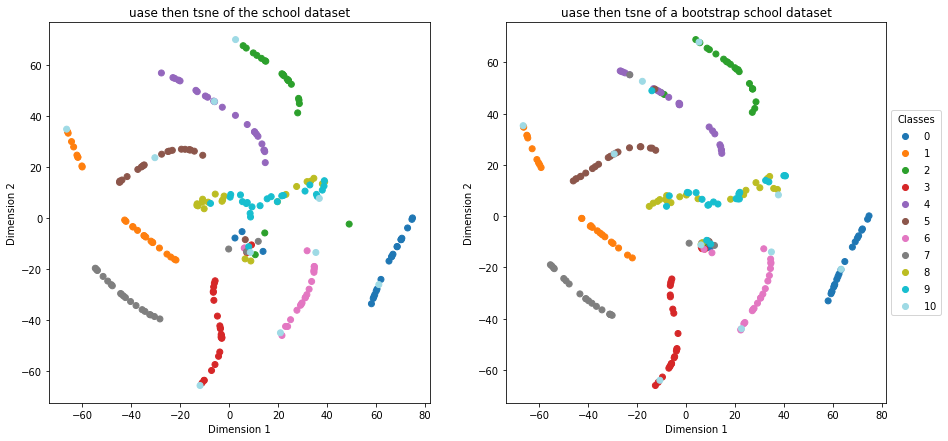

In [41]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
ax1.set_title("uase then tsne of the school dataset")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_tsne_df1["Dimension_1"], yhat_tsne_df1["Dimension_2"], c=yhat_tsne_df1["tau"], cmap='tab20')
ax2.set_title("uase then tsne of a bootstrap school dataset")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.legend(*scatter.legend_elements(), title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [45]:
# umap this embedding
from umap import UMAP
umap = UMAP(n_components=2, random_state=0)

yhat_umap = umap.fit_transform(yhat)

In [46]:
yhat_umap_df = pd.DataFrame(yhat_umap, columns=["Dimension_1", "Dimension_2"])

# add column for the matrix it is
yhat_umap_df["Matrix"] = np.repeat(range(B+1), len(node_labels))
# repeats tau list the len of A_true_boots_list times
yhat_umap_df["node_labels"] = (node_labels.tolist()*(B+1))

yhat_umap_df0 = yhat_umap_df[yhat_umap_df["Matrix"] == 0]
yhat_umap_df1 = yhat_umap_df[yhat_umap_df["Matrix"] == 1]

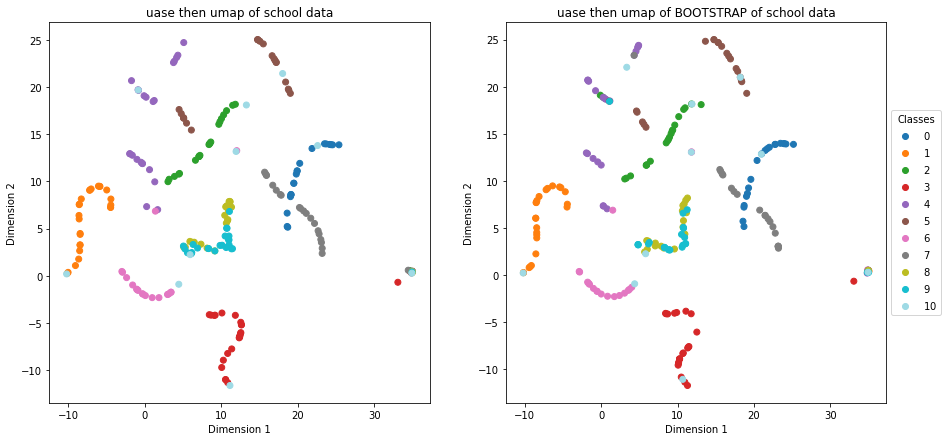

In [47]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_umap_df0["Dimension_1"], yhat_umap_df0["Dimension_2"], c=yhat_umap_df0["node_labels"], cmap='tab20')
ax1.set_title("uase then umap of school data")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_umap_df1["Dimension_1"], yhat_umap_df1["Dimension_2"], c=yhat_umap_df1["node_labels"], cmap='tab20')
ax2.set_title("uase then umap of BOOTSTRAP of school data")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.legend(*scatter.legend_elements(), title="Classes", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Now want to do some variance estimation from the bootstraps - going to test various $k$ values 

100%|██████████| 100/100 [00:06<00:00, 14.97it/s]


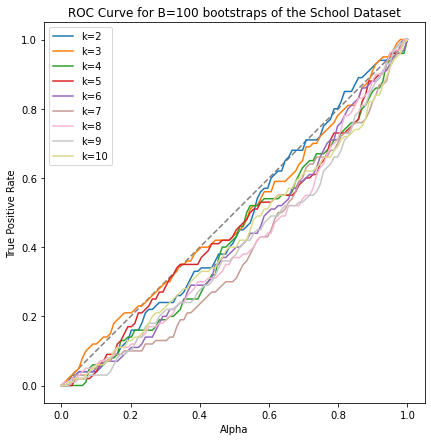

The value of k with the smallest area between the ROC curve and the diagonal is 3 with an area of 0.0227.


In [147]:
from matplotlib import cm

random.seed(100)
np.random.seed(100)

B = 100
d = 11

# Get the tab20 color palette
colors = cm.get_cmap('tab20', 10)

# Initialize lists to store ROC curves and areas
roc_curves = []
areas = []
alphas = np.linspace(0, 1, 100)

for k_value in range(2, 11):
    k = k_value

    p_vals = []
    A_boots_list = []

    for b in tqdm(range(B)):
        p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        p_vals.append(p_val)
        A_boots_list.append(A_boots)

    # Provided code
    p_hat_list = p_vals
    roc = []

    for alpha in alphas:
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Interpolating ROC for plotting
    roc_interpolated = np.interp(alphas, alphas, roc)

    # Store ROC curve data for plotting
    roc_curves.append((k, roc_interpolated))

    # Calculate the area between ROC and y=x line
    x = np.linspace(0, 1, 100)
    roc_interpolated = np.interp(x, alphas, roc)
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below
    areas.append((k, total_area))

# Find the k with the smallest area
best_k, smallest_area = min(areas, key=lambda x: x[1])

# Plot ROC curves for all k values
plt.figure(figsize=(10, 7))

# Plot y=x line
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")

# Plot each ROC curve with a different color
for idx, (k, roc) in enumerate(roc_curves):
    plt.plot(alphas, roc, color=colors(idx), label=f'k={k}')

# Set title, aspect ratio, and legend
plt.title(f"ROC Curve for B={B} bootstraps of the School Dataset")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('True Positive Rate')

# Save the plot to a file
plt.savefig('roc_curve_comparison.png', dpi=300)  # Save as PNG with high resolution

# Show the plot
plt.show()

# Print the k with the smallest area
print(f"The value of k with the smallest area between the ROC curve and the diagonal is {best_k} with an area of {smallest_area:.4f}.")



In [148]:
k = best_k
print(f"Best k: {k}")

Best k: 3


 15%|█▌        | 3/20 [00:00<00:00, 21.61it/s]

100%|██████████| 20/20 [00:01<00:00, 16.64it/s]


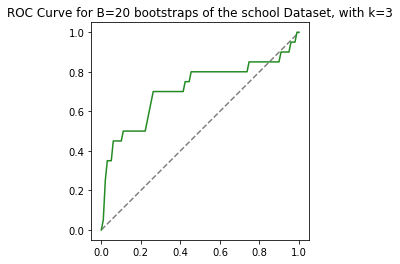

Total area (above and below y=x): 0.2222687542705908 for k=3


In [149]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20
d = 10

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [150]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [151]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (labels.tolist())*(B+1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

In [152]:
# tsne this embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=0)

# df = yadf[(yadf["Matrix"] == 0) | (yadf['Matrix'] == 1)]

yhat_tsne = tsne.fit_transform(yhat)

In [153]:
yhat_tsne_df = pd.DataFrame(yhat_tsne, columns=["Dimension_1", "Dimension_2"])

In [154]:
yhat_tsne_df = pd.DataFrame(yhat_tsne)
# rename the columns
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])] 
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(labels))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = (labels.tolist()*(B+1))

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]

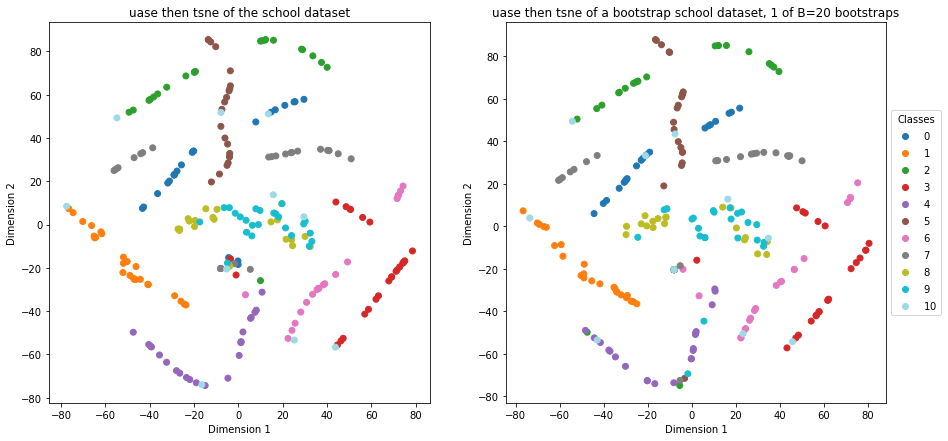

In [155]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
ax1.set_title("uase then tsne of the school dataset")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_tsne_df1["Dimension_1"], yhat_tsne_df1["Dimension_2"], c=yhat_tsne_df1["tau"], cmap='tab20')
ax2.set_title(f"uase then tsne of a bootstrap school dataset, 1 of B={B} bootstraps")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.legend(*scatter.legend_elements(), title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [156]:
# umap this embedding
from umap import UMAP
umap = UMAP(n_components=2, random_state=0)

yhat_umap = umap.fit_transform(yhat)

In [157]:
yhat_umap_df = pd.DataFrame(yhat_umap, columns=["Dimension_1", "Dimension_2"])

# add column for the matrix it is
yhat_umap_df["Matrix"] = np.repeat(range(B+1), len(node_labels))
# repeats tau list the len of A_true_boots_list times
yhat_umap_df["node_labels"] = (node_labels.tolist()*(B+1))

yhat_umap_df0 = yhat_umap_df[yhat_umap_df["Matrix"] == 0]
yhat_umap_df1 = yhat_umap_df[yhat_umap_df["Matrix"] == 1]

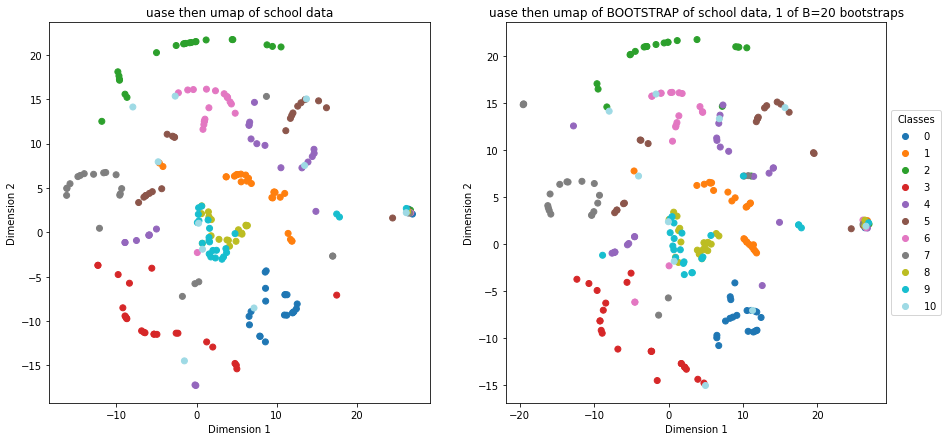

In [158]:
# plot two figures for the two different dfs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot the first df
scatter = ax1.scatter(yhat_umap_df0["Dimension_1"], yhat_umap_df0["Dimension_2"], c=yhat_umap_df0["node_labels"], cmap='tab20')
ax1.set_title("uase then umap of school data")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# plot the second df
scatter = ax2.scatter(yhat_umap_df1["Dimension_1"], yhat_umap_df1["Dimension_2"], c=yhat_umap_df1["node_labels"], cmap='tab20')
ax2.set_title(f"uase then umap of BOOTSTRAP of school data, 1 of B={B} bootstraps")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")

# plt.colorbar(scatter)
plt.legend(*scatter.legend_elements(), title="Classes", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Gonna try with B=20 here and TSNE

In [169]:
# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

In [174]:
yadf.head(2)

,Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,Dimension_7,Dimension_8,Dimension_9,Dimension_10,tau,Matrix,NodeNumber
0,-1.238581e-18,-3.040149e-20,-9.740729e-19,1.763442e-16,9.124531e-19,-2.849298e-19,-5.597839e-20,-2.286905e-20,-2.128701e-17,0.0,0,0,0
1,2.316685e-20,5.048756e-20,5.502865e-18,1.566567e-19,2.648052e-17,-3.364382e-18,-1.054953e-18,-1.291716e-19,1.050264e-32,0.0,0,0,1


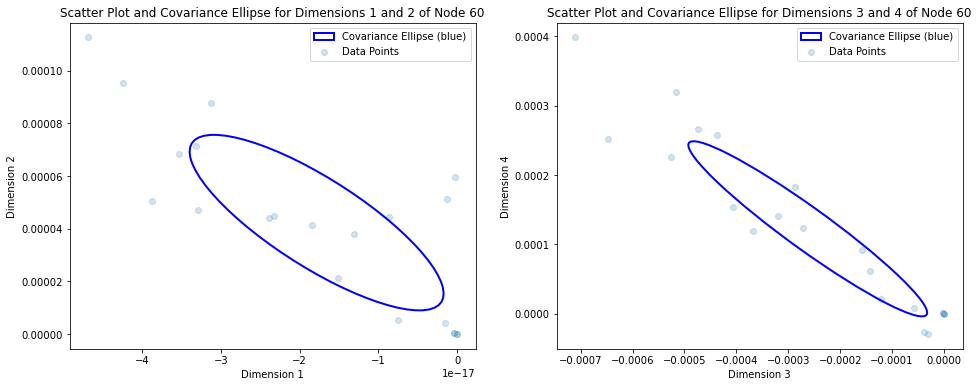

In [217]:
'''calculate mean and convariance for all d dimensions and plot the first 2 dimensions and the 3rd and 4th dimensions'''
fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 6))

# Assuming d is defined somewhere earlier in the code
node_number = 60
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Calculate the mean and covariance considering all d dimensions
mean_d_dim = np.mean(data_d_dim, axis=0)
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Eigen decomposition of the covariance matrix (considering all d dimensions)
eigenvalues, eigenvectors = np.linalg.eigh(cov_d_dim)
order = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[order]
eigenvectors = eigenvectors[:, order]

def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)

# Plotting the first 2 dimensions
ax = axes[0]
data_2d = data_d_dim[:, 0:2]
ax.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.2, label='Data Points')
plot_ellipse(ax, mean_d_dim[:2], cov_d_dim[:2, :2], 'blue')
ax.set_title(f'Scatter Plot and Covariance Ellipse for Dimensions 1 and 2 of Node {node_number}')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

# Plotting the 3rd and 4th dimensions
ax = axes[1]
data_3d = data_d_dim[:, 2:4]
ax.scatter(data_3d[:, 0], data_3d[:, 1], alpha=0.2, label='Data Points')
plot_ellipse(ax, mean_d_dim[2:4], cov_d_dim[2:4, 2:4], 'blue')
ax.set_title(f'Scatter Plot and Covariance Ellipse for Dimensions 3 and 4 of Node {node_number}')
ax.set_xlabel('Dimension 3')
ax.set_ylabel('Dimension 4')
ax.legend()

plt.show()

In [173]:
'''calculate mean and convariance for all d dimensions for each node'''
mean_vectors = []
cov_matrices = []

for i in range(len(node_labels)):
    # Assuming d is defined somewhere earlier in the code
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    mean_vectors.append(mean_d_dim)
    cov_matrices.append(cov_d_dim)

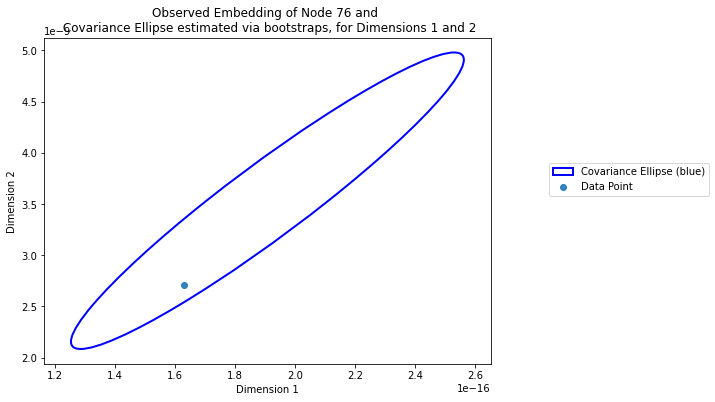

In [212]:
# Create a single plot
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(8, 6))

# Filter data for node number 76 and select the relevant dimensions
node_number = 76
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Calculate the mean and covariance considering all d dimensions
mean_d_dim = np.mean(data_d_dim, axis=0)
cov_d_dim = np.cov(data_d_dim, rowvar=False)

point = data_d_dim[0]

# Plotting only the first two dimensions
data_2d = data_d_dim[:, 0:2]
ax.scatter(point[0], point[1], alpha=0.9, label='Data Point')
plot_ellipse(ax, mean_d_dim[:2], cov_d_dim[:2, :2], 'blue')
ax.set_title(f'Observed Embedding of Node {node_number} and \n Covariance Ellipse estimated via bootstraps, for Dimensions 1 and 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))

plt.show()

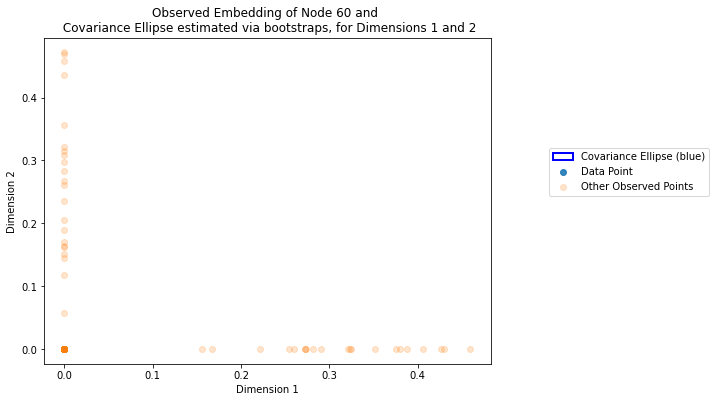

In [218]:
# Create a single plot
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(8, 6))

# Filter data for node number 76 and select the relevant dimensions
node_number = 60
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Calculate the mean and covariance considering all d dimensions
mean_d_dim = np.mean(data_d_dim, axis=0)
cov_d_dim = np.cov(data_d_dim, rowvar=False)

point = data_d_dim[0]
obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()


# Plotting only the first two dimensions
data_2d = data_d_dim[:, 0:2]
ax.scatter(point[0], point[1], alpha=0.9, label='Data Point')
ax.scatter(obs_points[:,0], obs_points[:,1], alpha=0.2, label='Other Observed Points')
plot_ellipse(ax, mean_d_dim[:2], cov_d_dim[:2, :2], 'blue')
ax.set_title(f'Observed Embedding of Node {node_number} and \n Covariance Ellipse estimated via bootstraps, for Dimensions 1 and 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))

plt.show()

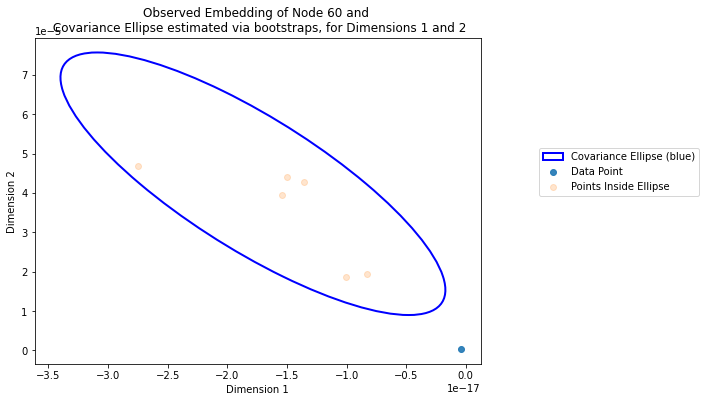

In [221]:
# Function to check if points are within the ellipse
def points_within_ellipse(points, mean, cov):
    # Calculate the Mahalanobis distance from the mean
    inv_cov = np.linalg.inv(cov)
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Calculate the threshold for being inside the ellipse
    threshold = 1.0  # This can be adjusted depending on the desired confidence level
    
    return mahalanobis_distances <= threshold

# Function to plot ellipse
def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)

# Create a single plot
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(8, 6))

# Filter data for node number and select the relevant dimensions
node_number = 60
d = 5  # Adjust if you have a different value for d
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Calculate the mean and covariance considering all d dimensions
mean_d_dim = np.mean(data_d_dim, axis=0)
cov_d_dim = np.cov(data_d_dim, rowvar=False)

point = data_d_dim[0]
obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

# Plotting only the first two dimensions
data_2d = data_d_dim[:, 0:2]
obs_points_2d = obs_points[:, 0:2]

# Filter points within the ellipse
inside_ellipse = points_within_ellipse(obs_points_2d, mean_d_dim[:2], cov_d_dim[:2, :2])

ax.scatter(point[0], point[1], alpha=0.9, label='Data Point')
ax.scatter(obs_points_2d[inside_ellipse, 0], obs_points_2d[inside_ellipse, 1], alpha=0.2, label='Points Inside Ellipse')
plot_ellipse(ax, mean_d_dim[:2], cov_d_dim[:2, :2], 'blue')
ax.set_title(f'Observed Embedding of Node {node_number} and \n Covariance Ellipse estimated via bootstraps, for Dimensions 1 and 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))

plt.show()


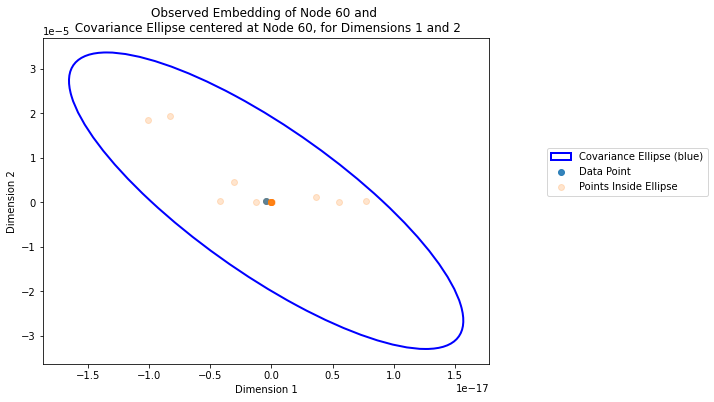

In [224]:
# Create a single plot
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(8, 6))

# Filter data for node number and select the relevant dimensions
node_number = 60
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Calculate the mean and covariance considering all d dimensions
mean_d_dim = np.mean(data_d_dim, axis=0)
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# Use the point corresponding to the specific node_number in matrix 0 as the center
point = data_d_dim[0]
obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

# Plotting only the first two dimensions
data_2d = data_d_dim[:, 0:2]
obs_points_2d = obs_points[:, 0:2]

# Filter points within the ellipse
inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

ax.scatter(point[0], point[1], alpha=0.9, label='Data Point')
ax.scatter(obs_points_2d[inside_ellipse, 0], obs_points_2d[inside_ellipse, 1], alpha=0.2, label='Points Inside Ellipse')
plot_ellipse(ax, point[:2], cov_d_dim[:2, :2], 'blue')
ax.set_title(f'Observed Embedding of Node {node_number} and \n Covariance Ellipse centered at Node {node_number}, for Dimensions 1 and 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0.5))

plt.show()
